In [18]:
# Loading in the dependencies

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import IPython.display as display

In [19]:
# Loading in the outputted drift rate csv file and changing the typo hihi

drift_rates = pd.read_csv('drift_rates.csv')
drift_rates['Category'] = drift_rates['Category'].replace({
    'low domonance': 'low dominance'  
})

/opt/homebrew/Caskroom/miniconda/base/envs/aai/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/aai/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/aai/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/aai/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: F

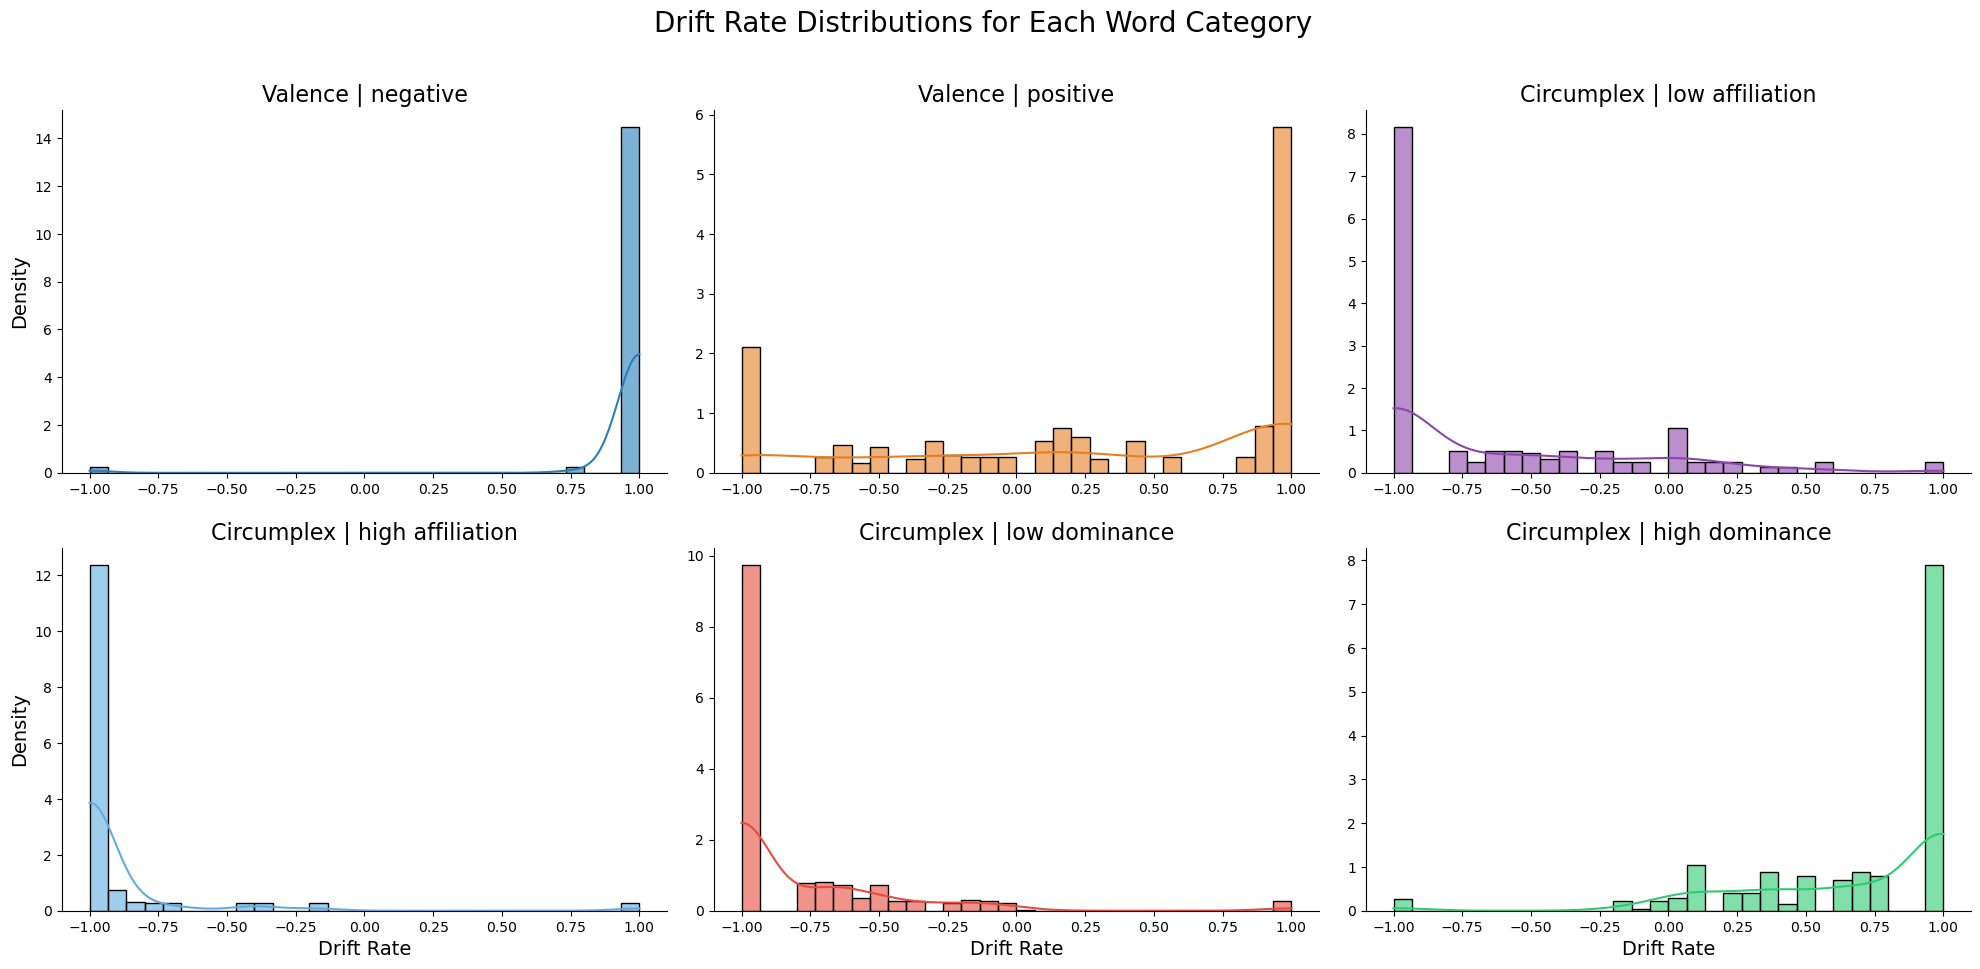

In [20]:
# Having a look at the data distributions

drift_rates['Dimension_Category'] = drift_rates['Dimension'] + " | " + drift_rates['Category']

selected_combinations = [
    "Valence | negative",
    "Valence | positive",
    "Circumplex | low affiliation",
    "Circumplex | high affiliation",
    "Circumplex | low dominance",
    "Circumplex | high dominance",
]

filtered_drift_rates = drift_rates[
    drift_rates['Dimension_Category'].isin(selected_combinations)
]

palette = {
    "Valence | negative": "#E74C3C",  
    "Valence | positive": "#2ECC71",       
    "Circumplex | low affiliation": "#8E44AD",  
    "Circumplex | high affiliation": "#2980B9",
    "Circumplex | low dominance": "#5DADE2",   
    "Circumplex | high dominance": "#E67E22",   
}

g = sns.FacetGrid(
    filtered_drift_rates,
    col="Dimension_Category",
    col_wrap=3,
    sharex=False,
    sharey=False,
    height=4,
    aspect=1.5
)

for ax, (dimension_category, subset) in zip(g.axes.flatten(), filtered_drift_rates.groupby("Dimension_Category")):
    color = palette.get(dimension_category, "grey") 
    sns.histplot(
        data=subset,
        x="DriftRate",
        kde=True,
        stat="density",
        common_norm=False,
        bins=30,
        color=color,
        ax=ax,
        alpha=0.6
    )

g.set_axis_labels("Drift Rate", "Density", size = 14)
g.set_titles(col_template="{col_name}", size = 16)

g.tight_layout()
g.figure.set_size_inches(20, 10)
g.figure.subplots_adjust(top=0.88)
g.figure.suptitle("Drift Rate Distributions for Each Word Category ", fontsize=20)

g.figure.show()

In [ ]:
# Seeing the correlations between the drift rates of the clinical scores and the word categories

results = []

# Group by Dimension_Category and Measure
for (dimension_category, measure), group in filtered_drift_rates.groupby(["Dimension_Category", "Measure"]):
    if len(group) >= 5:
        r, p = pearsonr(group["Score"], group["DriftRate"])
        
        dimension, category = dimension_category.split(" | ")

        # Significance label
        if p < 0.001:
            sig = '***'
        elif p < 0.01:
            sig = '**'
        elif p < 0.05:
            sig = '*'
        else:
            sig = 'ns'
        
        results.append({
            "Dimension_Category": dimension_category,
            "Measure": measure,
            "r": round(r, 3),
            "p": format(p, ".3g"),
            "Significance": sig
        })

# Create DataFrame
results_df = pd.DataFrame(results)

# Create a new column that combines r and significance for nicer table cells
results_df["r_with_sig"] = results_df["r"].astype(str) + " " + results_df["Significance"]

# Pivot
pivot_table = results_df.pivot(
    index="Dimension_Category",
    columns="Measure",
    values="r_with_sig"
)

# Sort rows in desired order if needed
order = [
    "Valence | negative",
    "Valence | positive",
    "Circumplex | low affiliation",
    "Circumplex | high affiliation",
    "Circumplex | low dominance",
    "Circumplex | high dominance"
]
pivot_table = pivot_table.reindex(order)

# Display

display.display(pivot_table)

Measure,BDI,BFNE,FPES,LSAS,RSES,SPIN,STAI-S,STAI-T
Dimension_Category,,,,,,,,
Valence | negative,0.462 ***,0.012 ns,-0.012 ns,0.148 ns,-0.355 **,0.1 ns,0.238 ns,0.272 *
Valence | positive,-0.536 ***,-0.258 ns,-0.21 ns,-0.44 ***,0.533 ***,-0.417 **,-0.357 **,-0.347 **
Circumplex | low affiliation,0.383 **,0.018 ns,0.095 ns,0.193 ns,-0.351 **,0.139 ns,0.23 ns,0.272 *
Circumplex | high affiliation,-0.314 *,0.222 ns,0.205 ns,0.068 ns,0.088 ns,0.102 ns,-0.046 ns,-0.003 ns
Circumplex | low dominance,0.367 **,-0.093 ns,-0.125 ns,0.036 ns,-0.196 ns,-0.025 ns,0.152 ns,0.12 ns
Circumplex | high dominance,-0.471 ***,-0.442 ***,-0.397 **,-0.555 ***,0.573 ***,-0.532 ***,-0.475 ***,-0.451 ***
